## 구매 내역 길이 분포 확인

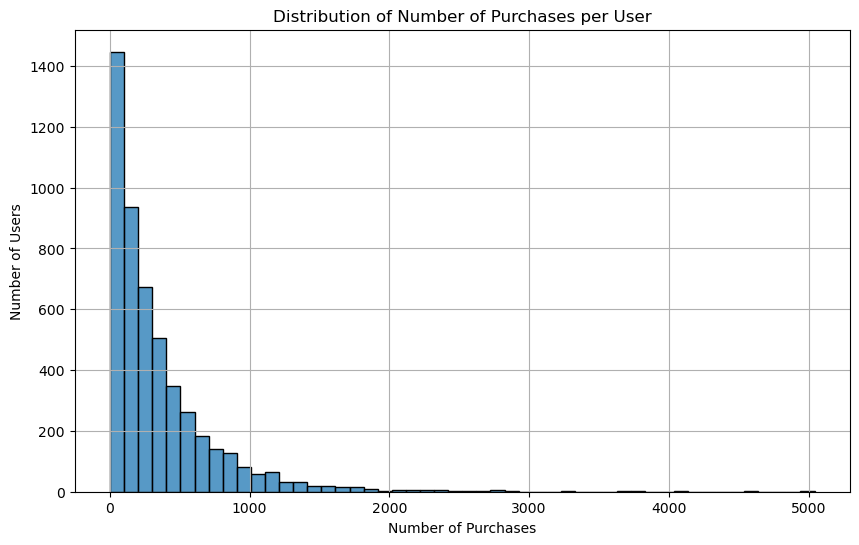

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 그룹화
ama_sort = pd.read_csv('ama_sort.csv')
grouped = ama_sort.groupby("Survey ResponseID")

# 각 유저의 구매 내역 개수 구하기
purchase_counts = grouped.size().reset_index(name='count')

# 히스토그램 
plt.figure(figsize=(10, 6))
sns.histplot(purchase_counts['count'], bins=50, kde=False)
plt.title('Distribution of Number of Purchases per User')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()


## sliding window 사용해서 구매 내역 데이터 분할

In [2]:
ama_sort.head()

,Unnamed: 0,Order Date,Quantity,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID
0,0,2018-12-04,1.0,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF
1,1,2018-12-22,1.0,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF
2,2,2018-12-25,1.0,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF
3,3,2018-12-25,1.0,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF
4,4,2019-02-18,1.0,Micro USB Cable Android Charger - Syncwire [2-...,B01GFB2E9M,COMPUTER_PROCESSOR,R_01vNIayewjIIKMF


In [3]:
ama_sort['Category'].unique()

array(['FLASH_MEMORY', 'HEADPHONES', 'DISHWARE_BOWL', ..., 'WATCHES',
       'COMPUTER_VIDEO_GAME_CONTOLLER', 'FSN_DEVICES'], dtype=object)

기존의 amazon dataset에 존재하는 Category로는 상품군 군집화를 할 수 없어서, amazon에서 Category를 크롤링해서 카테고리 계층 정보를 활용해서 상품군 분류를 하기로 결정

### 크롤링한 카테고리 이름 사용

In [4]:
import pandas as pd

# 데이터 불러오기
tran = pd.read_csv('transaction_categorized_n.csv')
tran.head()

,Order Date,ASIN/ISBN (Product Code),Category,Survey ResponseID
0,2018-12-04,B0143RTB1E,"('Electronics', 'Computers & Accessories', 'Co...",R_01vNIayewjIIKMF
1,2018-12-22,B01MA1MJ6H,"('Electronics', 'Headphones, Earbuds & Accesso...",R_01vNIayewjIIKMF
2,2018-12-25,B06XWF9HML,"('Beauty & Personal Care', 'Shave & Hair Remov...",R_01vNIayewjIIKMF
3,2018-12-25,B00837ZOI0,"('Beauty & Personal Care', 'Shave & Hair Remov...",R_01vNIayewjIIKMF
4,2019-02-18,B01GFB2E9M,"('Electronics', 'Computers & Accessories', 'Co...",R_01vNIayewjIIKMF


In [ ]:
tran['Category'].unique()

array(["('Electronics', 'Computers & Accessories', 'Computer Accessories & Peripherals', 'Memory Cards', 'SD Cards')",
       "('Electronics', 'Headphones, Earbuds & Accessories', 'Headphones & Earbuds', 'Earbud Headphones')",
       '(\'Beauty & Personal Care\', \'Shave & Hair Removal\', "Men\'s", \'Shaving Accessories\', \'Shaving Soap Bowls\')',
       ...,
       "('Books', 'Cookbooks, Food & Wine', 'Regional & International', 'European')",
       "('Toys & Games', 'Games & Accessories', 'Casino Equipment', 'Blackjack Equipment', 'Blackjack Sets')",
       "('Collectibles & Fine Art', 'Sports', 'Trading Cards', 'Sets', 'Sealed Sets')"],
      dtype=object)

카테고리 계층 정보가 너무 많아서, 이것을 그대로 추천 모델에 넣으면 token 수 초과. <br>
카테고리 계층을 문자로 encoding하기

### 방법 1: 카테고리 계층 전체를 문자로 인코딩

In [15]:
import pandas as pd

# 데이터 불러오기
tran = pd.read_csv('transaction_categorized_n.csv')

# Category 고유값 추출 및 인코딩
unique_categories = tran["Category"].astype(str).unique()
category_to_id = {cat: f"C{idx:04d}" for idx, cat in enumerate(unique_categories)}
id_to_category = {v: k for k, v in category_to_id.items()}

# 인코딩 적용
tran["Encoded_Category"] = tran["Category"].astype(str).map(category_to_id)

# 매핑 결과 저장
pd.DataFrame([
    {"Encoded_ID": enc_id, "Original_Category": cat}
    for cat, enc_id in category_to_id.items()
]).to_csv("category_encoding_map_n.csv", index=False)

print("실행 완료")


실행 완료


In [16]:
tran.head()

,Order Date,ASIN/ISBN (Product Code),Category,Survey ResponseID,Encoded_Category
0,2018-12-04,B0143RTB1E,"('Electronics', 'Computers & Accessories', 'Co...",R_01vNIayewjIIKMF,C0000
1,2018-12-22,B01MA1MJ6H,"('Electronics', 'Headphones, Earbuds & Accesso...",R_01vNIayewjIIKMF,C0001
2,2018-12-25,B06XWF9HML,"('Beauty & Personal Care', 'Shave & Hair Remov...",R_01vNIayewjIIKMF,C0002
3,2018-12-25,B00837ZOI0,"('Beauty & Personal Care', 'Shave & Hair Remov...",R_01vNIayewjIIKMF,C0003
4,2019-02-18,B01GFB2E9M,"('Electronics', 'Computers & Accessories', 'Co...",R_01vNIayewjIIKMF,C0004


In [18]:
from tqdm import tqdm
import random
import numpy as np
import pandas as pd

sequence_data = []
grouped = tran.groupby("Survey ResponseID")

for user_id, group in tqdm(grouped, desc="Processing users", total=tran["Survey ResponseID"].nunique()):
    group = group.sort_values("Order Date").reset_index(drop=True)
    n = len(group)
    if n < 5:
        continue

    # 날짜, 인코딩된 카테고리, ASIN 추출
    dates = group["Order Date"].to_numpy(dtype='datetime64[D]')
    encoded_cats = group["Encoded_Category"].astype(str).to_numpy()
    asins = group["ASIN/ISBN (Product Code)"].astype(str).to_numpy()

    idx = 0
    while idx < n - 1:
        start_date = dates[idx]
        end_limit = start_date + np.timedelta64(730, 'D')

        max_end_idx = np.searchsorted(dates, end_limit, side='right') - 1
        window_len = max_end_idx - idx + 1

        if window_len >= 6:
            if window_len >= 20:
                upper_bound = min(40, int(0.5 * window_len))
                rand_len = random.randint(20, upper_bound) if upper_bound > 20 else upper_bound
            else:
                rand_len = window_len

            window_asins = asins[idx:idx + rand_len]
            window_cats = encoded_cats[idx:idx + rand_len]
            window_dates = dates[idx:idx + rand_len]

            # ASIN|EncodedCategory 형태
            asin_cat_pairs = [f"{a}|{c}" for a, c in zip(window_asins, window_cats)]
            order_date_sequence = [str(d) for d in window_dates]  # datetime64 → str

            prefix = "User bought " + ", then ".join(asin_cat_pairs[:-1]) + ". What comes next?"
            target = window_asins[rand_len - 1]

            sequence_data.append({
                "user_id": user_id,
                "input": prefix,
                "target": target,
                "order_date_sequence": order_date_sequence
            })

            stride = max(5, rand_len // 4)
            idx += stride
        else:
            idx += 1

pd.DataFrame(sequence_data).to_csv("t5_train_pair_encoded_n.csv", index=False)
print("시퀀스 데이터 저장 완료: t5_train_pair_encoded_n.csv")


Processing users: 100%|██████████| 4691/4691 [00:11<00:00, 421.12it/s]


시퀀스 데이터 저장 완료: t5_train_pair_encoded_n.csv


### 학습 데이터
- user_id: 고객
- input: 구매 내역 시퀀스
- target: 맞춰야 하는 정답값
- order_date_sequence: input과 target의 order date(순서대로)

In [19]:
sequence_data[0]

{'user_id': 'R_01vNIayewjIIKMF',
 'input': 'User bought B0143RTB1E|C0000, then B01MA1MJ6H|C0001, then B06XWF9HML|C0002, then B00837ZOI0|C0003, then B01GFB2E9M|C0004, then B00NH13S44|C0004, then B07L84ZZXC|C0005, then B07CG71KQ1|C0006, then B079GFF4HZ|C0001, then B01M0Q84BR|C0007, then B01MA1MJ6H|C0001, then B073JYC4XM|C0008, then B00I7DT454|C0009, then B01MA1MJ6H|C0001, then B0043T7FXE|C0010, then B01M2V05RE|C0001, then B07BCZMBNR|C0011, then B01MZ956SX|C0012, then B07JCJP1DK|C0013, then B07JD5B8SP|C0013, then B071XGLB1S|C0014, then B07D5V2ZXD|C0015, then B01BNEWDFQ|C0016, then B01NBYY28W|C0017, then B019FGCOW6|C0018. What comes next?',
 'target': 'B072JYDQ7N',
 'order_date_sequence': ['2018-12-04',
  '2018-12-22',
  '2018-12-25',
  '2018-12-25',
  '2019-02-18',
  '2019-02-18',
  '2019-04-23',
  '2019-05-02',
  '2019-05-02',
  '2019-05-11',
  '2019-05-16',
  '2019-06-15',
  '2019-06-15',
  '2019-06-25',
  '2019-07-14',
  '2019-08-02',
  '2019-08-10',
  '2019-09-09',
  '2019-09-09',
  '

### 방법 2: 카테고리 계층에서 top2의 카테고리들을 그대로 학습 데이터로 구성

In [20]:
import pandas as pd
from tqdm import tqdm
import random
import numpy as np

# 데이터 불러오기
tran = pd.read_csv('transaction_categorized_n.csv')

# 문자열로 바꾸고 eval 적용 (문자열 튜플이면 ast.literal_eval도 가능)
tran["Category"] = tran["Category"].apply(eval)  # 또는 ast.literal_eval

# Top-2 계층만 추출해 문자열로 변환
def extract_top2(cat):
    if isinstance(cat, (list, tuple)) and len(cat) >= 2:
        return f"{cat[0]}>{cat[1]}"
    elif isinstance(cat, (list, tuple)) and len(cat) == 1:
        return f"{cat[0]}"

tran["Top2_Category"] = tran["Category"].apply(extract_top2)

# 시퀀스 생성
sequence_data_2 = []
grouped = tran.groupby("Survey ResponseID")

for user_id, group in tqdm(grouped, desc="Processing users", total=tran["Survey ResponseID"].nunique()):
    group = group.sort_values("Order Date").reset_index(drop=True)
    n = len(group)
    if n < 5:
        continue

    # 날짜, Top2 카테고리, ASIN 추출
    dates = group["Order Date"].to_numpy(dtype='datetime64[D]')
    top2_cats = group["Top2_Category"].astype(str).to_numpy()
    asins = group["ASIN/ISBN (Product Code)"].astype(str).to_numpy()

    idx = 0
    while idx < n - 1:
        start_date = dates[idx]
        end_limit = start_date + np.timedelta64(730, 'D')

        max_end_idx = np.searchsorted(dates, end_limit, side='right') - 1
        window_len = max_end_idx - idx + 1

        if window_len >= 6:
            if window_len >= 20:
                upper_bound = min(20, int(0.5 * window_len))
                rand_len = random.randint(20, upper_bound) if upper_bound > 20 else upper_bound
            else:
                rand_len = window_len

            window_asins = asins[idx:idx + rand_len]
            window_cats = top2_cats[idx:idx + rand_len]
            window_dates = dates[idx:idx + rand_len]

            # ASIN|Top2Category 형태
            asin_cat_pairs = [f"{a}|{c}" for a, c in zip(window_asins, window_cats)]
            order_date_sequence = [str(d) for d in window_dates]  # datetime64 → str

            prefix = "User bought " + ", then ".join(asin_cat_pairs[:-1]) + ". What comes next?"
            target = window_asins[rand_len - 1]

            sequence_data_2.append({
                "user_id": user_id,
                "input": prefix,
                "target": target,
                "order_date_sequence": order_date_sequence
            })

            stride = max(5, rand_len // 4)
            idx += stride
        else:
            idx += 1

# 저장
pd.DataFrame(sequence_data_2).to_csv("t5_train_pair_top2_n.csv", index=False)
print("시퀀스 데이터 저장 완료: t5_train_pair_top2_n.csv")


Processing users: 100%|██████████| 4691/4691 [00:13<00:00, 335.46it/s]


시퀀스 데이터 저장 완료: t5_train_pair_top2_n.csv


In [33]:
top2_cats

array(['Beauty & Personal Care>Hair Care',
       'Health & Household>Medical Supplies & Equipment',
       'Beauty & Personal Care>Personal Care',
       'Patio, Lawn & Garden>Gardening & Lawn Care',
       'Beauty & Personal Care>Skin Care', 'Sports & Outdoors>Sports',
       'Beauty & Personal Care>Skin Care', 'Books>Literature & Fiction',
       'Beauty & Personal Care>Shave & Hair Removal',
       'Books>Biographies & Memoirs',
       'Tools & Home Improvement>Lighting & Ceiling Fans',
       'Health & Household>Vitamins, Minerals & Supplements',
       'Health & Household>Vitamins, Minerals & Supplements',
       'Health & Household>Health Care', 'Health & Household>Health Care',
       'Health & Household>Medical Supplies & Equipment',
       'Electronics>Computers & Accessories',
       'Electronics>Television & Video', 'Electronics>Home Audio',
       'Electronics>Home Audio', 'Electronics>Home Audio',
       'Movies & TV>Featured Categories',
       'Movies & TV>Featured Cate

In [21]:
sequence_data_2[0]

{'user_id': 'R_01vNIayewjIIKMF',
 'input': 'User bought B0143RTB1E|Electronics>Computers & Accessories, then B01MA1MJ6H|Electronics>Headphones, Earbuds & Accessories, then B06XWF9HML|Beauty & Personal Care>Shave & Hair Removal, then B00837ZOI0|Beauty & Personal Care>Shave & Hair Removal, then B01GFB2E9M|Electronics>Computers & Accessories, then B00NH13S44|Electronics>Computers & Accessories, then B07L84ZZXC|Clothing, Shoes & Jewelry>Sport Specific Clothing, then B07CG71KQ1|Electronics>Computers & Accessories, then B079GFF4HZ|Electronics>Headphones, Earbuds & Accessories, then B01M0Q84BR|Home & Kitchen>Kitchen & Dining, then B01MA1MJ6H|Electronics>Headphones, Earbuds & Accessories, then B073JYC4XM|Electronics>Computers & Accessories, then B00I7DT454|Health & Household>Sexual Wellness, then B01MA1MJ6H|Electronics>Headphones, Earbuds & Accessories, then B0043T7FXE|Electronics>Computers & Accessories, then B01M2V05RE|Electronics>Headphones, Earbuds & Accessories, then B07BCZMBNR|Cell Phone

## train, valid, test로 분할(7:2:1)

방법 1 데이터 분할

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# CSV 불러오기
df = pd.read_csv("t5_train_pair_encoded_n.csv")

# 먼저 train (70%) vs temp (30%) 로 분할
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# 그 다음 temp을 valid (20%) vs test (10%)로 다시 분할
valid_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)  # 0.1 / 0.3 = 1/3

# 각각 저장
train_df.to_csv("t5_train_pair_final_nn.csv", index=False)
valid_df.to_csv("t5_valid_pair_final_nn.csv", index=False)
test_df.to_csv("t5_test_pair_final_nn.csv", index=False)

print("저장 완료!")


방법 2 데이터 분할

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# CSV 불러오기
df = pd.read_csv("t5_train_pair_top2_n.csv")

# 먼저 train (70%) vs temp (30%) 로 분할
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# 그 다음 temp을 valid (20%) vs test (10%)로 다시 분할
valid_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)  # 0.1 / 0.3 = 1/3

# 각각 저장
train_df.to_csv("t5_train_pair_final_t2.csv", index=False)
valid_df.to_csv("t5_valid_pair_final_t2.csv", index=False)
test_df.to_csv("t5_test_pair_final_t2.csv", index=False)

print("저장 완료!")


## 구매 주기 기반으로 추천 결과 필터링

In [ ]:
import pandas as pd
from datetime import datetime
import ast
from tqdm import tqdm
import re

# 파일 경로
rec_path = "test_r20_n.csv"
ama_path = "transaction_categorized_n.csv"
cycle_path = "Purchase_Cycle.csv"
encoding_map_path = "category_encoding_map_n.csv"

# 데이터 불러오기
df_rec = pd.read_csv(rec_path)
df_ama = pd.read_csv(ama_path)
df_cycle = pd.read_csv(cycle_path)
df_encoding = pd.read_csv(encoding_map_path)

# 날짜 처리
df_ama['Order Date'] = pd.to_datetime(df_ama['Order Date'])

# 매핑 테이블
asin_to_category = df_ama.set_index("ASIN/ISBN (Product Code)")["Category"].to_dict()
asin_to_date = df_ama.set_index(["Survey ResponseID", "ASIN/ISBN (Product Code)"])["Order Date"].to_dict()
category_to_cycle = df_cycle.set_index("Category")["Purchase_Cycle"].to_dict()
encoded_to_original = df_encoding.set_index("Encoded_ID")["Original_Category"].to_dict()

# top_20 문자열 → 리스트로 변환
df_rec["top_20_predictions"] = df_rec["top_20_predictions"].apply(ast.literal_eval)
df_rec["order_date_sequence"] = df_rec["order_date_sequence"].apply(ast.literal_eval)

# 조건 만족한 결과를 저장할 컬럼 초기화
# df_rec["satisfied_pairs"] = [[]]
df_rec["satisfied_pairs"] = [[] for _ in range(len(df_rec))]

# 총 개수 카운트 변수
total_satisfied_pairs = 0

# 각 row별 계산
for idx, row in tqdm(df_rec.iterrows(), total=len(df_rec), desc="Processing"):
    user_id = row["user_id"]
    top20_asins = row["top_20_predictions"]
    order_dates = [pd.to_datetime(d) for d in row["order_date_sequence"]]
    last_order_date = order_dates[-1]

    # input에서 제품코드|인코딩카테고리 추출
    input_parts = row["input"].split("then")
    input_encoded_cats = []
    for part in input_parts:
        if "|" in part:
            encoded_cat = part.strip().split("|")[-1]
            match = re.search(r"C\d+", encoded_cat)
            if match:
                encoded_cat = match.group(0).strip()
                original_cat = encoded_to_original.get(encoded_cat, None)
                if original_cat:
                    input_encoded_cats.append(original_cat)

    satisfied_pairs = []

    # top20 예측 결과 순회
    for pred_asin in top20_asins:
        pred_cat = asin_to_category.get(pred_asin, None)
        pred_date = last_order_date
        if pred_cat is None or pd.isna(pred_date):
            continue

        for input_idx, input_cat in enumerate(input_encoded_cats):
            if pred_cat == input_cat:
                if input_idx < len(order_dates):
                    input_order_date = order_dates[input_idx]
                    day_diff = abs((input_order_date - pred_date).days)

                    purchase_cycle = category_to_cycle.get(pred_cat, None)
                    if purchase_cycle is not None and day_diff <= purchase_cycle:
                        satisfied_pairs.append((pred_asin, pred_cat))
                        break

    # user별 조건 만족 쌍 추가
    df_rec.at[idx, "satisfied_pairs"] = satisfied_pairs
    total_satisfied_pairs += len(satisfied_pairs)

# 유저별 조건 만족 쌍 개수 컬럼 추가
df_rec["num_satisfied_pairs"] = df_rec["satisfied_pairs"].apply(len)

# 결과 저장
df_rec.to_csv("test_r20_cycle_match_updated.csv", index=False)
print("저장 완료: test_r20_cycle_match_updated.csv")


In [ ]:
df_rec = pd.read_csv('test_r20_cycle_match_updated.csv')
total_rows = len(df_rec)
nonzero_count = (df_rec["num_satisfied_pairs"] != 0).sum()
ratio = nonzero_count / total_rows

print(f"전체 시퀀스 수 (유저 구매 시퀀스 수): {total_rows}")
print(f"재구매 주기 이전에 잘못 추천한 시퀀스 수: {nonzero_count}")
print(f"잘못된 추천 비율(시퀀스 기준): {ratio:.4f} ({ratio*100:.2f}%)")
total_top20_count = 0
for cats in df["top_20_categories"]:
    if isinstance(cats, list):
        total_top20_count += sum(1 for c in cats if c is not None)
print()
print(f"전체 추천된 제품 수: {total_top20_count}")

total_satisfied_count = df_rec["num_satisfied_pairs"].sum()
print(f"재구매 주기 이전에 잘못 추천한 제품 수: {total_satisfied_count}")
nratio = total_satisfied_count / total_top20_count
print(f"잘못된 추천 비율(제품 기준): {nratio:.4f} ({nratio*100:.2f}%)")


In [ ]:
import pandas as pd
from datetime import datetime
import ast
from tqdm import tqdm
import re

# 파일 경로
rec_path = "test_r20_n.csv"
ama_path = "transaction_categorized_n.csv"
cycle_path = "Purchase_Cycle.csv"
encoding_map_path = "category_encoding_map_n.csv"

# 데이터 불러오기
df_rec = pd.read_csv(rec_path)
df_ama = pd.read_csv(ama_path)
df_cycle = pd.read_csv(cycle_path)
df_encoding = pd.read_csv(encoding_map_path)

# 날짜 처리
df_ama['Order Date'] = pd.to_datetime(df_ama['Order Date'])

# 매핑 테이블
asin_to_category = df_ama.set_index("ASIN/ISBN (Product Code)")["Category"].to_dict()
asin_to_date = df_ama.set_index(["Survey ResponseID", "ASIN/ISBN (Product Code)"])["Order Date"].to_dict()
category_to_cycle = df_cycle.set_index("Category")["Purchase_Cycle"].to_dict()
encoded_to_original = df_encoding.set_index("Encoded_ID")["Original_Category"].to_dict()

# 리스트 변환
df_rec["order_date_sequence"] = df_rec["order_date_sequence"].apply(ast.literal_eval)

# 결과 저장용 컬럼 초기화
df_rec["unsatisfied_pairs"] = [[] for _ in range(len(df_rec))]

total_unsatisfied_pairs = 0

# 각 row별 계산
for idx, row in tqdm(df_rec.iterrows(), total=len(df_rec), desc="Processing"):
    user_id = row["user_id"]
    target_asin = row["target"].strip()
    order_dates = [pd.to_datetime(d) for d in row["order_date_sequence"]]
    last_order_date = order_dates[-1]

    # target 카테고리 가져오기
    target_cat = asin_to_category.get(target_asin, None)
    if target_cat is None:
        continue

    unsatisfied_pairs = []

    # input parsing: 제품코드|인코딩카테고리 추출
    input_parts = row["input"].split("then")
    for idx_input, part in enumerate(input_parts):
        if "|" in part:
            encoded_cat = part.strip().split("|")[-1]
            match = re.search(r"C\d+", encoded_cat)
            if match:
                encoded_cat = match.group(0).strip()
                original_cat = encoded_to_original.get(encoded_cat, None)
                if original_cat:
                    if original_cat == target_cat:
                        if idx_input < len(order_dates):
                            input_order_date = order_dates[idx_input]
                            day_diff = abs((input_order_date - last_order_date).days)

                            purchase_cycle = category_to_cycle.get(target_cat, None)
                            if purchase_cycle is not None and day_diff <= purchase_cycle:
                                # 구매주기가 지났지 않은 경우 → unsatisfied
                                unsatisfied_pairs.append((target_asin, target_cat, input_order_date.date(), last_order_date.date(), day_diff, purchase_cycle))

    df_rec.at[idx, "unsatisfied_pairs"] = unsatisfied_pairs
    total_unsatisfied_pairs += len(unsatisfied_pairs)

# 유저별 조건 만족 안된 쌍 개수 컬럼 추가
df_rec["num_satisfied_pairs"] = df_rec["unsatisfied_pairs"].apply(len)

# 결과 저장
df_rec.to_csv("test_r20_unsatisfied_pairs.csv", index=False)
print("저장 완료: test_r20_unsatisfied_pairs.csv")


In [ ]:
df_rec = pd.read_csv('test_r20_unsatisfied_pairs.csv')
total_rows = len(df_rec)
nonzero_count = (df_rec["num_satisfied_pairs"] != 0).sum()
ratio = nonzero_count / total_rows

print(f"전체 시퀀스 수 (유저별 구매 시퀀스 수): {total_rows}")
print(f"재구매 주기가 아직 되지 않았음에도 실제로 다시 구매가 발생한 시퀀스 수: {nonzero_count}")
print(f"실제 재구매 조기 발생 비율: {ratio:.4f} ({ratio*100:.2f}%)")
